# Advanced Computer Vision - Week_04 - Auto encoders

In [1]:
# pytorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import plotly.express as px
import plotly.io as pio
import os
import random

# torchsummary for easy checking and debugging
from torchsummary import summary

# torchvision for downloading and processing dataset
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST

# others for notebook UI and latent space visualization
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os

# Dataset prepair

In [2]:
# This function is a collate function for data loading in PyTorch. It's used with DataLoader to preprocess batches of data.
# It takes a batch of data samples as input and performs the necessary preprocessing steps.

def collate_fn(batch):
    # Define a series of transformations to apply to each image in the batch.
    process = transforms.Compose([
                transforms.ToTensor(),  # Convert PIL images to PyTorch tensors.
                transforms.Pad([2])     # Pad each image with 2 pixels on all sides.
                ])
 
    # Process each image in the batch using the defined transformations.
    # We use a list comprehension to apply the transformations to each image in the batch.
    x = [process(data[0]) for data in batch]

    # Concatenate the processed images along a new dimension to create a batch tensor.
    # We add a new dimension because PyTorch expects input data to be in the format (batch_size, channels, height, width).
    x = torch.cat(x).unsqueeze(1)

    # Extract labels from the batch of data samples and convert them to LongTensor.
    # It's important to use LongTensor for labels to match the expected data type for classification tasks.
    y = torch.LongTensor([data[1] for data in batch])

    # Return the processed batch of images (x) along with their corresponding labels (y).
    return x, y


In [3]:
batch_size = 2 ** 4

In [4]:
# Define a list of label names corresponding to the classes in the FashionMNIST dataset.
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Download or load the FashionMNIST dataset for training and validation.
# If the dataset is not available locally, it will be downloaded to the specified directory.
train_data = FashionMNIST("./MNIST_DATA", train=True, download=True)  # Training data
valid_data = FashionMNIST("./MNIST_DATA", train=False, download=True)  # Validation data

# Create DataLoader objects to load batches of training and validation data.
# DataLoader is a PyTorch utility for batching and shuffling data during training.
# It takes the dataset, batch size, shuffle option, and collate function as parameters.
train_loader = DataLoader(train_data, batch_size=batch_size, 
                          shuffle=True, collate_fn=collate_fn)  # Training DataLoader
valid_loader = DataLoader(valid_data, batch_size=batch_size, 
                          shuffle=False, collate_fn=collate_fn)  # Validation DataLoader


TypeError: 'DataLoader' object is not subscriptable

Inspecting train data: 
Batch shape:  torch.Size([16, 1, 32, 32])


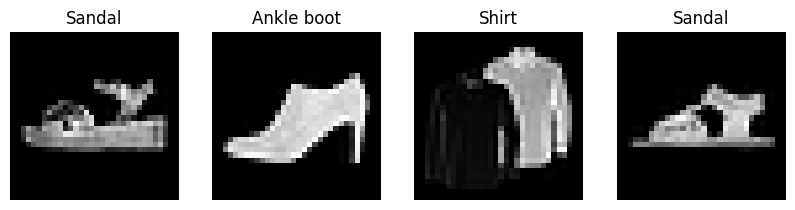

In [6]:
# Dataset inspection loop to visualize a batch of training data.
print("Inspecting train data: ")

# Iterate over batches of data in the train_loader DataLoader.
for _, data in enumerate(train_loader):
    print("Batch shape: ", data[0].shape)  # Print the shape of the batch.

    # Create a subplot with 4 columns to display 4 images in the batch.
    fig, ax = plt.subplots(1, 4, figsize=(10, 4))

    # Iterate over the first 4 samples in the batch.
    for i in range(4):
        # Display each image in the subplot.
        ax[i].imshow(data[0][i].squeeze(), cmap="gray")  # Show the image in grayscale.
        ax[i].axis("off")  # Turn off axis labels.
        ax[i].set_title(labels[data[1][i]])  # Set the title as the corresponding label name.

    plt.show()  # Show the plotted images.
    break  # Break the loop after inspecting the first batch.


# Model

In [7]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
LAYERS = 3
KERNELS = [3, 3, 3]
CHANNELS = [32, 64, 128]
STRIDES = [2, 2, 2]
LINEAR_DIM = 2048

class Encoder(nn.Module):
    
    def __init__(self, output_dim=2, use_batchnorm=False, use_dropout=False):
        super(Encoder, self).__init__()
        
        # bottleneck dimensionality
        self.output_dim = output_dim

        # variables deciding if using dropout and batchnorm in model
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm
    
        # convolutional layer hyperparameters
        self.layers = LAYERS
        self.kernels = KERNELS
        self.channels = CHANNELS
        self.strides = STRIDES
        self.conv = self.get_convs()
        
        # layers for latent space projection
        self.fc_dim = LINEAR_DIM
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(self.fc_dim, self.output_dim)
    
    
    def get_convs(self):
        """
        Generating convolutional layers based on
        model's hyperparameters.
        """
        # Initialize an empty container to store layers sequentially.
        conv_layers = nn.Sequential()
        
        for i in range(self.layers):
            # If it's the first layer, input channels are 1.
            if i == 0:
                conv_layers.add_module(
                    f"conv_{i+1}",  # Name the module sequentially.
                    nn.Conv2d(1, self.channels[i], 
                              kernel_size=self.kernels[i],
                              stride=self.strides[i],
                              padding=1)
                )
            else:
                conv_layers.add_module(
                    f"conv_{i+1}",
                    nn.Conv2d(self.channels[i-1], self.channels[i],
                              kernel_size=self.kernels[i],
                              stride=self.strides[i],
                              padding=1)
                )
            
            # If specified, add batch normalization after each convolutional layer.
            if self.use_batchnorm:
                conv_layers.add_module(f"batchnorm_{i+1}", nn.BatchNorm2d(self.channels[i]))
            
            # Apply GELU activation function after each convolutional layer.
            conv_layers.add_module(f"gelu_{i+1}", nn.GELU())
            
            # If specified, add dropout after each convolutional layer.
            if self.use_dropout:
                conv_layers.add_module(f"dropout_{i+1}", nn.Dropout2d(0.15))

        return conv_layers
    
    
    def forward(self, x):
        # Pass input through convolutional layers.
        x = self.conv(x)
        
        # Flatten the output tensor to feed into linear layers.
        x = self.flatten(x)
        
        # Project the flattened tensor to the latent space.
        return self.linear(x), x

    
# Instantiate the decoder with specified settings and send it to the appropriate device.
encodere = Encoder(use_batchnorm=True, use_dropout=False).to(DEVICE)
# Display the summary of the decoder architecture.de
summary(encodere, (1, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              GELU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              GELU-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
              GELU-9            [-1, 128, 4, 4]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                    [-1, 2]           4,098
Total params: 97,218
Trainable params: 97,218
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [9]:
class Decoder(nn.Module):
    def __init__(self, input_dim=2, use_batchnorm=False, use_dropout=False):
        super(Decoder, self).__init__()
        
        # Variables deciding if using dropout and batchnorm in the model.
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm

        self.fc_dim = LINEAR_DIM
        self.input_dim = input_dim
        
        # Convolutional layer hyperparameters.
        self.layers = LAYERS
        self.kernels = KERNELS
        self.channels = CHANNELS[::-1]  # Flip the channel dimensions.
        self.strides = STRIDES
        
        # In the decoder, we first do fully connected projection, then convolutional layers.
        self.linear = nn.Linear(self.input_dim, self.fc_dim)
        self.conv = self.get_convs()

        # Output convolutional layer to reconstruct the original input shape.
        self.output = nn.Conv2d(self.channels[-1], 1, kernel_size=1, stride=1)
    

    def get_convs(self):
        """
        Generating transposed convolutional layers based on
        model's hyperparameters.
        """
        # Initialize an empty container to store layers sequentially.
        conv_layers = nn.Sequential()
        for i in range(self.layers):
            if i == 0:
                conv_layers.add_module(
                    f"conv_transpose_{i+1}",
                    nn.ConvTranspose2d(self.channels[i], self.channels[i],
                                       kernel_size=self.kernels[i],
                                       stride=self.strides[i],
                                       padding=1,
                                       output_padding=1)
                )
            else:
                conv_layers.add_module(
                    f"conv_transpose_{i+1}",
                    nn.ConvTranspose2d(self.channels[i-1], self.channels[i],
                                       kernel_size=self.kernels[i],
                                       stride=self.strides[i],
                                       padding=1,
                                       output_padding=1)
                )
            
            # If specified, add batch normalization after each transposed convolutional layer.
            if self.use_batchnorm and i != self.layers - 1:
                conv_layers.add_module(f"batchnorm_{i+1}", nn.BatchNorm2d(self.channels[i]))

            # Apply GELU activation function after each transposed convolutional layer.
            conv_layers.add_module(f"gelu_{i+1}", nn.GELU())

            # If specified, add dropout after each transposed convolutional layer.
            if self.use_dropout:
                conv_layers.add_module(f"dropout_{i+1}", nn.Dropout2d(0.15))

        return conv_layers
    
    
    def forward(self, x):
        # Pass input through the linear layer for projection.
        x = self.linear(x)
        
        # Reshape the 3D tensor to a 4D tensor.
        x = x.reshape(x.shape[0], 128, 4, 4)
        
        # Pass the reshaped tensor through the convolutional layers.
        x = self.conv(x)
        
        # Return the reconstructed output.
        return self.output(x)
    
# Instantiate the decoder with specified settings and send it to the appropriate device.
decoder = Decoder(use_batchnorm=True, use_dropout=True).to(DEVICE)
# Display the summary of the decoder architecture.
summary(decoder, (1, 2))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 2048]           6,144
   ConvTranspose2d-2            [-1, 128, 8, 8]         147,584
       BatchNorm2d-3            [-1, 128, 8, 8]             256
              GELU-4            [-1, 128, 8, 8]               0
         Dropout2d-5            [-1, 128, 8, 8]               0
   ConvTranspose2d-6           [-1, 64, 16, 16]          73,792
       BatchNorm2d-7           [-1, 64, 16, 16]             128
              GELU-8           [-1, 64, 16, 16]               0
         Dropout2d-9           [-1, 64, 16, 16]               0
  ConvTranspose2d-10           [-1, 32, 32, 32]          18,464
             GELU-11           [-1, 32, 32, 32]               0
        Dropout2d-12           [-1, 32, 32, 32]               0
           Conv2d-13            [-1, 1, 32, 32]              33
Total params: 246,401
Trainable params:

In [11]:
# Classifier on top of Encoder
class Classifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super(Classifier, self).__init__()
        self.encoder = Encoder(use_batchnorm=True, use_dropout=False).to(DEVICE)
        self.fc = nn.Linear(2048, num_classes)
    
    def forward(self, x):
        _, x = self.encoder(x)  # Use only the classification output
        x = self.fc(x)
        x = F.softmax(x, dim=1)  # Apply softmax for probabilities
        return x

# Instantiate the decoder with specified settings and send it to the appropriate device.

num_classes = 10  # Number of classes
# Instantiate the decoder with specified settings and send it to the appropriate device.
encodere = Encoder(use_batchnorm=True, use_dropout=False).to(DEVICE)
classifier = Classifier(encodere, num_classes).to(DEVICE)


summary(classifier, (1, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              GELU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              GELU-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
              GELU-9            [-1, 128, 4, 4]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                    [-1, 2]           4,098
          Encoder-12      [[-1, 2], [-1, 2048]]               0
           Linear-13                   [-1, 10]          20,490
Total params: 117,708
Trainable params:

# BASIC


In [12]:
device

NameError: name 'device' is not defined

In [13]:
# Initialize empty lists to store metrics
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Initialize encoder and classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_dummy = Encoder(use_batchnorm=True, use_dropout=False)
classifier = Classifier(encoder_dummy, 10)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

classifier = classifier.to(device)

# Training loop
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(train_loader, desc="Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    return train_loss, train_acc

# Validation loop
def validate(model, valid_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(valid_loader, desc="Validation"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    valid_loss = total_loss / len(valid_loader)
    valid_acc = correct / total
    return valid_loss, valid_acc

# Train and validate the model
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train(classifier, train_loader, optimizer, criterion)
    valid_loss, valid_acc = validate(classifier, valid_loader, criterion)

        # Append metrics to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/10:
Train Loss: 1.6251, Train Acc: 0.8375
Valid Loss: 1.6043, Valid Acc: 0.8586


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2/10:
Train Loss: 1.5875, Train Acc: 0.8739
Valid Loss: 1.5967, Valid Acc: 0.8637


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3/10:
Train Loss: 1.5755, Train Acc: 0.8855
Valid Loss: 1.5783, Valid Acc: 0.8829


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4/10:
Train Loss: 1.5658, Train Acc: 0.8952
Valid Loss: 1.5693, Valid Acc: 0.8920


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5/10:
Train Loss: 1.5593, Train Acc: 0.9016
Valid Loss: 1.5675, Valid Acc: 0.8939


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6/10:
Train Loss: 1.5544, Train Acc: 0.9066
Valid Loss: 1.5704, Valid Acc: 0.8908


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7/10:
Train Loss: 1.5518, Train Acc: 0.9093
Valid Loss: 1.5661, Valid Acc: 0.8943


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8/10:
Train Loss: 1.5467, Train Acc: 0.9143
Valid Loss: 1.5720, Valid Acc: 0.8892


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 9/10:
Train Loss: 1.5431, Train Acc: 0.9179
Valid Loss: 1.5662, Valid Acc: 0.8943


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 10/10:
Train Loss: 1.5406, Train Acc: 0.9204
Valid Loss: 1.5608, Valid Acc: 0.8998


In [14]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Instantiate encoder and decoder modules.
        self.encoder= Encoder(use_batchnorm=True, use_dropout=False)
        self.decoder = Decoder(input_dim=2, use_batchnorm=True, use_dropout=False)
        
    def forward(self, x):
        # Pass input through the encoder, then through the decoder.
        x, _ = self.encoder(x)
        return self.decoder(x)
# Instantiate the autoencoder model and send it to the appropriate device.
model = AutoEncoder().to(DEVICE)
# Display the summary of the autoencoder architecture.
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              GELU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              GELU-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
              GELU-9            [-1, 128, 4, 4]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                    [-1, 2]           4,098
          Encoder-12      [[-1, 2], [-1, 2048]]               0
           Linear-13                 [-1, 2048]           6,144
  ConvTranspose2d-14            [-1, 12

In [32]:
import plotly.io as pio
def plotting(step:int=0, show=False, width=1000, height=1000):
    """
    Function to generate and save a scatter plot of encoded validation data.
    
    Parameters:
        step (int): Step number of the training process.
        show (bool): Flag to indicate whether to display the plot or not.
        width (int): Width of the plot.
        height (int): Height of the plot.
    """
    # Switch the model to evaluation mode
    model.eval()
    
    points = []         # List to store encoded points
    label_idcs = []     # List to store label indices
    
    # Create directory for saving plots if it doesn't exist
    path = "./ScatterPlots"
    if not os.path.exists(path): os.mkdir(path)
    
    # Iterate over validation data loader
    for i, data in enumerate(valid_loader):
        img, label = [d.to(DEVICE) for d in data]
        
        # Encode validation images using the model's encoder
        proj, _ = model.encoder(img)
        points.extend(proj.detach().cpu().numpy())
        label_idcs.extend(label.detach().cpu().numpy())
        
        del img, label   # Delete tensors to free up memory
    
    points = np.array(points)  # Convert list of points to numpy array
    
    # Generate random colors per label
    num_labels = len(np.unique(label_idcs))
    colors = [px.colors.qualitative.Set1[i % len(px.colors.qualitative.Set1)] for i in range(num_labels)]
    label_colors = [colors[label] for label in label_idcs]
    
    # Convert label indices to label names
    label_names = [labels[label] for label in label_idcs]
    
    # Create a scatter plot using Plotly Express
    fig = px.scatter(x=points[:, 0], y=points[:, 1], color=label_names, 
                     color_discrete_sequence=label_colors, opacity=0.9, 
                     labels={'x': 'Dimension 1', 'y': 'Dimension 2', 'color': 'Labels'})
    fig.update_layout(width=width, height=height)
    
    if show: 
        # Show the plot if 'show' flag is True
        fig.show()
    else: 
        # Save the plot as an image if 'show' flag is False
        pio.write_image(fig, f"{path}/Step_{step:03d}.png")
        model.train()  # Switch back to training mode after plotting


# Train pipeline

In [33]:
learning_rate = 0.0005  # Learning rate for optimizer
criterion = nn.MSELoss()  # Loss criterion (Mean Squared Error)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
# AdamW optimizer with specified learning rate and weight decay

# For mixed precision training
scaler = torch.cuda.amp.GradScaler()  # Gradient scaler for mixed precision training

steps = 0  # Variable to track the number of training steps

In [34]:
def train(model, dataloader, criterion, optimizer, scaler, save_distrib=False):
    """
    Function to train the autoencoder model.

    Parameters:
        model (nn.Module): Autoencoder model to be trained.
        dataloader (DataLoader): DataLoader containing the training data.
        criterion: Loss criterion used for training.
        optimizer: Optimization algorithm used for updating model parameters.
        scaler: Gradient scaler for mixed precision training.
        save_distrib (bool): Flag to indicate whether to save latent space plots.
        
    Returns:
        float: Average training loss over all batches.
    """
    # steps is used to track training progress, purely for latent space plots
    global steps 
    
    model.train()  # Set the model to training mode
    train_loss = 0.0  # Initialize training loss
    
    # Initialize tqdm progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, 
                     leave=False, position=0, desc="Train")

    for i, batch in enumerate(dataloader):
        
        optimizer.zero_grad()  # Reset gradients
        x = batch[0].to(DEVICE)  # Move data to device
        
        # Implement mixed precision training
        with torch.cuda.amp.autocast():
            y_recons = model(x)  # Forward pass
            loss = criterion(y_recons, x)  # Compute loss
        
        train_loss += loss.item()  # Update training loss
        
        scaler.scale(loss).backward()  # Backpropagate gradients
        scaler.step(optimizer)  # Update model parameters
        scaler.update()  # Update gradient scaler
        
        # Update tqdm progress bar with current loss and learning rate
        batch_bar.set_postfix(
            loss=f"{train_loss/(i+1):.4f}",
            lr=f"{optimizer.param_groups[0]['lr']:.4f}"
        )
        
        # Saving latent space plots
        if steps % 10 == 0 and save_distrib and steps <= 400:
            plotting(steps)
        
        batch_bar.update()  # Update progress bar
        steps += 1  # Increment training steps
        
        torch.cuda.empty_cache()  # Clear GPU cache
        del x, y_recons  # Delete unnecessary variables
    
    batch_bar.close()  # Close tqdm progress bar
    train_loss /= len(dataloader)  # Compute average training loss

    return train_loss  # Return average training loss


In [35]:
def validate(model, dataloader, criterion):
    """
    Function to validate the autoencoder model.

    Parameters:
        model (nn.Module): Autoencoder model to be validated.
        dataloader (DataLoader): DataLoader containing the validation data.
        criterion: Loss criterion used for validation.
        
    Returns:
        float: Average validation loss over all batches.
    """
    model.eval()  # Set the model to evaluation mode
    valid_loss = 0.0  # Initialize validation loss
    
    # Initialize tqdm progress bar for validation
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True,
                     leave=False, position=0, desc="Validation")
    
    for i, batch in enumerate(dataloader):
        x = batch[0].to(DEVICE)  # Move data to device
        
        with torch.no_grad():
            y_recons = model(x)  # Forward pass (no gradient calculation)
            loss = criterion(y_recons, x)  # Compute loss
        
        valid_loss += loss.item()  # Update validation loss
        
        # Update tqdm progress bar with current loss and learning rate
        batch_bar.set_postfix(
            loss=f"{valid_loss/(i+1):.4f}",
            lr=f"{optimizer.param_groups[0]['lr']:.4f}"  # Note: optimizer is not defined in this function
        )
        batch_bar.update()  # Update progress bar
        
        torch.cuda.empty_cache()  # Clear GPU cache
        del x, y_recons  # Delete unnecessary variables
    
    batch_bar.close()  # Close tqdm progress bar
    valid_loss /= len(dataloader)  # Compute average validation loss
    
    return valid_loss  # Return average validation loss


## Train the model

In [37]:
epochs = 10  # Number of epochs for training
for i in range(epochs):
    curr_lr = float(optimizer.param_groups[0]["lr"])  # Current learning rate
    # Train the model for one epoch
    train_loss = train(model, train_loader, criterion, optimizer, scaler, save_distrib=False)
    # Validate the model
    valid_loss = validate(model, valid_loader, criterion)
    # Print epoch-wise training and validation losses along with current learning rate
    print(f"Epoch {i+1}/{epochs}\nTrain loss: {train_loss:.4f}\t Validation loss: {valid_loss:.4f}\tlr: {curr_lr:.4f}")


Train:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/10
Train loss: 0.0224	 Validation loss: 0.0219	lr: 0.0005


Train:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2/10
Train loss: 0.0221	 Validation loss: 0.0215	lr: 0.0005


Train:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3/10
Train loss: 0.0218	 Validation loss: 0.0213	lr: 0.0005


Train:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4/10
Train loss: 0.0215	 Validation loss: 0.0212	lr: 0.0005


Train:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5/10
Train loss: 0.0213	 Validation loss: 0.0210	lr: 0.0005


Train:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6/10
Train loss: 0.0212	 Validation loss: 0.0209	lr: 0.0005


Train:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7/10
Train loss: 0.0211	 Validation loss: 0.0208	lr: 0.0005


Train:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8/10
Train loss: 0.0209	 Validation loss: 0.0208	lr: 0.0005


Train:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 9/10
Train loss: 0.0208	 Validation loss: 0.0208	lr: 0.0005


Train:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 10/10
Train loss: 0.0207	 Validation loss: 0.0206	lr: 0.0005


In [ ]:
### PRETRAINT TRANING

In [20]:
model.encoder

Encoder(
  (conv): Sequential(
    (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batchnorm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gelu_1): GELU(approximate='none')
    (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batchnorm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gelu_2): GELU(approximate='none')
    (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batchnorm_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gelu_3): GELU(approximate='none')
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=2048, out_features=2, bias=True)
)

In [38]:
# Initialize empty lists to store metrics
train_losses_ea = []
train_accuracies_ea = []
valid_losses_ea = []
valid_accuracies_ea = []

# Initialize encoder and classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# encoder_dummy = Encoder(use_batchnorm=True, use_dropout=False)
copy_enc = model.encoder
classifier = Classifier(copy_enc, 10)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

classifier = classifier.to(device)

# Training loop
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(train_loader, desc="Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    return train_loss, train_acc

# Validation loop
def validate(model, valid_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(valid_loader, desc="Validation"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    valid_loss = total_loss / len(valid_loader)
    valid_acc = correct / total
    return valid_loss, valid_acc

# Train and validate the model
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train(classifier, train_loader, optimizer, criterion)
    valid_loss, valid_acc = validate(classifier, valid_loader, criterion)

        # Append metrics to lists
    train_losses_ea.append(train_loss)
    train_accuracies_ea.append(train_acc)
    valid_losses_ea.append(valid_loss)
    valid_accuracies_ea.append(valid_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/10:
Train Loss: 1.6216, Train Acc: 0.8417
Valid Loss: 1.6007, Valid Acc: 0.8613


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2/10:
Train Loss: 1.5833, Train Acc: 0.8780
Valid Loss: 1.5862, Valid Acc: 0.8758


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3/10:
Train Loss: 1.5725, Train Acc: 0.8883
Valid Loss: 1.5793, Valid Acc: 0.8814


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4/10:
Train Loss: 1.5644, Train Acc: 0.8967
Valid Loss: 1.5695, Valid Acc: 0.8918


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5/10:
Train Loss: 1.5579, Train Acc: 0.9027
Valid Loss: 1.5656, Valid Acc: 0.8958


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6/10:
Train Loss: 1.5516, Train Acc: 0.9093
Valid Loss: 1.5692, Valid Acc: 0.8910


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7/10:
Train Loss: 1.5466, Train Acc: 0.9147
Valid Loss: 1.5662, Valid Acc: 0.8950


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8/10:
Train Loss: 1.5439, Train Acc: 0.9169
Valid Loss: 1.5615, Valid Acc: 0.8997


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 9/10:
Train Loss: 1.5414, Train Acc: 0.9196
Valid Loss: 1.5626, Valid Acc: 0.8984


Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 10/10:
Train Loss: 1.5377, Train Acc: 0.9234
Valid Loss: 1.5559, Valid Acc: 0.9049


In [54]:
plotting(show=True)

In [55]:
from PIL import Image
import os

# Convert png images to gif
frames = []
imgs = sorted(os.listdir("./ScatterPlots"))

for im in imgs:
    new_frame = Image.open("./ScatterPlots/" + im)
    frames.append(new_frame)

frames[0].save("latentspace.gif", format="GIF",
               append_images=frames[1:],
               save_all=True,
               duration=200, loop=0)


# Laten space searhing

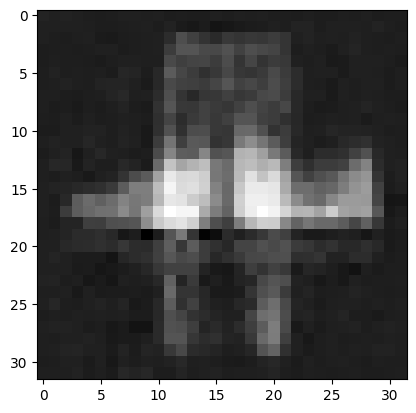

In [58]:
i = torch.tensor([[3.0,9.0]]).to(DEVICE)
img = model.decoder(i).to(DEVICE)


im = img.squeeze().detach().cpu()
plt.imshow(im, cmap="gray")

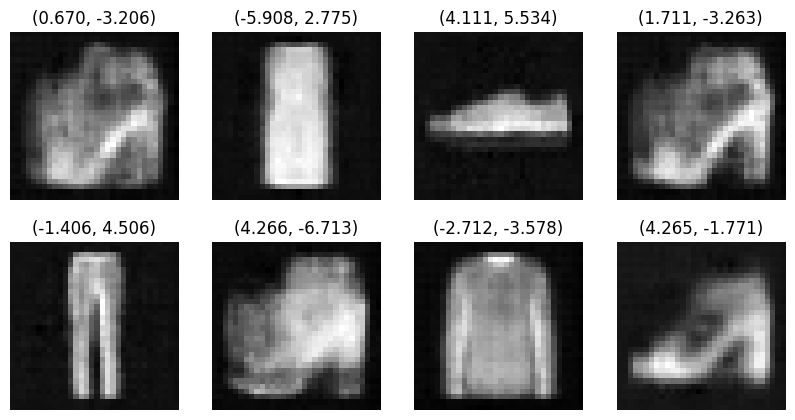

In [59]:
import random
import torch
import matplotlib.pyplot as plt

# randomly sample x and y values within specified ranges
xs = [random.uniform(-6.0, 8.0) for _ in range(8)]  # Random x values
ys = [random.uniform(-7.5, 10.0) for _ in range(8)]  # Random y values

# Combine x and y values into a list of (x, y) coordinate tuples
points = list(zip(xs, ys))

# Convert the coordinate tuples into a PyTorch tensor and move to the appropriate device (GPU)
coords = torch.tensor(points).unsqueeze(1).to(DEVICE)

# Define the number of rows and columns for subplots
nrows, ncols = 2, 4

# Create a figure and an array of axes for subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5))

# Set the model to evaluation mode
model.eval()

# Generate images for each coordinate using the trained autoencoder model
with torch.no_grad():
    generates = [model.decoder(coord)[0] for coord in coords]

# Plot the generated images on the subplots
idx = 0
for row in range(nrows):
    for col in range(ncols):
        ax = axes[row, col]  # Get the current axis
        im = generates[idx].squeeze().detach().cpu()  # Get the generated image
        ax.imshow(im, cmap="gray")  # Plot the image
        ax.axis("off")  # Turn off axis labels
        coord = coords[idx].detach().cpu().numpy()[0]  # Get the corresponding coordinate tuple
        ax.set_title(f"({coord[0]:.3f}, {coord[1]:.3f})")  # Set the title with the coordinate values
        idx += 1

# Display the plot
plt.show()

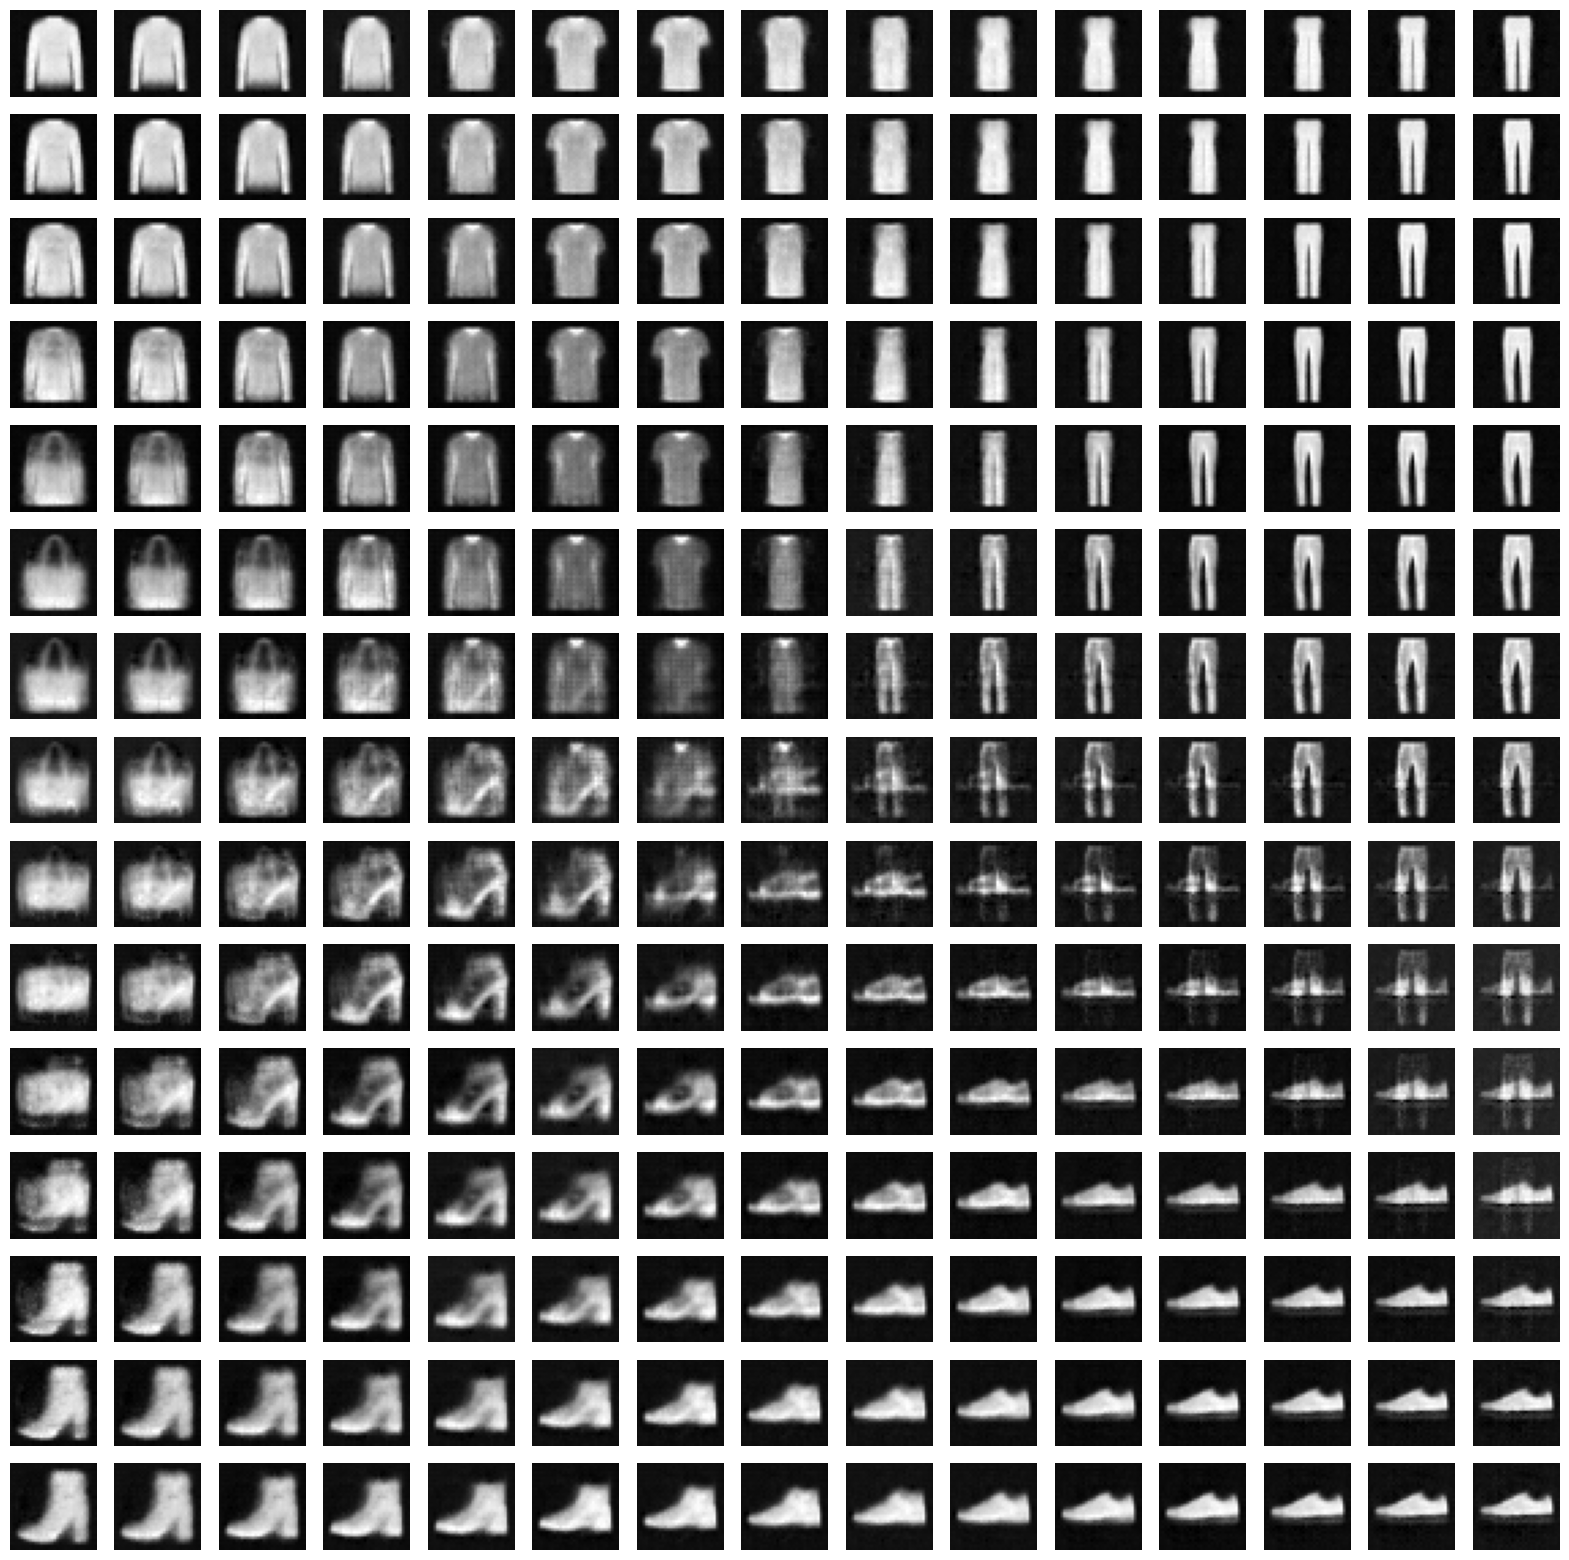

In [61]:
steps = 15  # Number of steps for sampling x and y values
Xses = np.linspace(-7.3, 8.0, steps)  # Generate x values within the specified range
Yses = np.linspace(-7.5, 10, steps)  # Generate y values within the specified range

nrows, ncols = steps, steps  # Number of rows and columns for subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20))  # Create subplots

# Loop through all x and y values
for idx, xx in enumerate(Xses):
    for idy, yy in enumerate(Yses):
        ax = axes[idx, idy]  # Get current axis
        i = torch.tensor([[float(xx), float(yy)]]).to(DEVICE)  # Convert x and y to tensor
        img = model.decoder(i).to(DEVICE)  # Decode the tensor to reconstruct the image
        im = img.squeeze().detach().cpu()  # Detach from computational graph and move to CPU
        ax.imshow(im, cmap="gray")  # Display the reconstructed image
        ax.axis("off")  # Turn off axis
plt.show()  # Display the subplots
